In [6]:
from matplotlib import pyplot as plt
import numpy as np
import cv2

In [7]:
# Global Variables

N = 320 # Image Size
G = 20 # Watermark Size
P = 50 # Max Moment

# Steps

T_STEP = int(P / 4) + 1
I_STEP = int(N / 8) + 1

In [8]:
%run -i ../ownlib/PHT-Library2.ipynb
%run -i ../ownlib/RIW-Library.ipynb
%run -i ../ownlib/Utility.ipynb
%run -i ../ownlib/Inverse-Geometric.ipynb

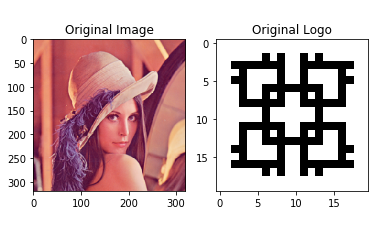

In [9]:
# Import images
ori_img = cv2.imread('../assets/lena.png') #BGR
ori_logo = cv2.imread('../assets/squares.png', 0)

# Preprocess Image
IMG_BGR = cv2.resize(ori_img, (N, N)) # Original Image
IMG_Y = getYFromBGR(IMG_BGR) #

# Preprocess Logo
LOGO = cv2.resize(ori_logo, (G,G))
LOGO = (LOGO >= 128) * 1

# Show Image and Logo
imgshow([[IMG_BGR, LOGO]], [['Original Image', 'Original Logo']])

Progress: [####################] 100.0%


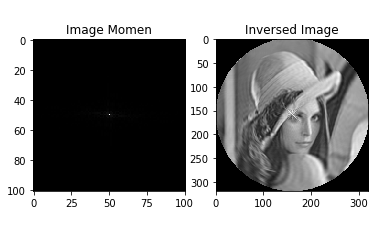

In [10]:
# Calculate Momen of Original Image
MOMEN = transformPHT(IMG_Y, N, P)
IMG_Y_INV = inversePHT(MOMEN, N, P)
imgshow([[MOMEN, IMG_Y_INV]], [['Image Momen', 'Inversed Image']])

Progress: [####################] 100.0%


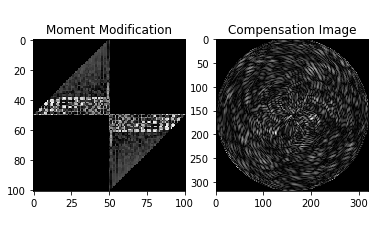

In [11]:
# Calculate Embedded Momen

# Watermarking Power
DELTA = 0.5

# Current Binary Value
matQ = np.floor(np.abs(MOMEN) / DELTA) % 2

# Set Watermark Position
P2 = P * 2 + 1

# Calculate Watermark Matrix
(doubleLogo, doubleFilter) = watermarkEmbed(LOGO, P)
        
# Modified Momen
XI = np.abs(MOMEN) - np.floor(np.abs(MOMEN) / DELTA) * DELTA

OMEGA = - XI
OMEGA = OMEGA + DELTA / 2 * (matQ == doubleLogo)
OMEGA = OMEGA + 3 * DELTA / 2 * np.logical_and(matQ != doubleLogo, np.logical_or(XI > DELTA / 2, np.abs(MOMEN) < DELTA))
OMEGA = OMEGA - DELTA / 2 * np.logical_and(matQ != doubleLogo, np.logical_and(XI <= DELTA / 2, np.abs(MOMEN) >= DELTA))

OMEGA = OMEGA / (np.abs(MOMEN) + 0.000000001) * MOMEN
OMEGA = OMEGA * doubleFilter

# Calculate Compensation Image
EPSILON = inversePHT(OMEGA, N, P)

# Show Modified Momen
imgshow([[OMEGA, EPSILON]], [['Moment Modification', 'Compensation Image']])

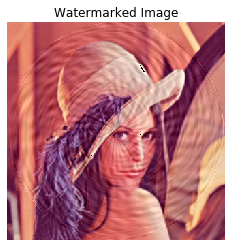

In [12]:
# Add Compensation Image to Original Image
# IMG_Y_WATERMARKED = IMG_Y + (EPSILON - np.min(IMG_Y_INV)) / (np.max(IMG_Y_INV) - np.min(IMG_Y_INV)) * 255
IMG_Y_WATERMARKED = IMG_Y + EPSILON

# Add Original Image back to YCRCB scheme
IMG_WATERMARKED = putYToBGR(IMG_Y_WATERMARKED, IMG_BGR)

imgshow1(IMG_WATERMARKED, 'Watermarked Image')

In [13]:
# Modified function   
def attackAndDisplay(image, title, isNeedAntiTranslation=False):
    processAndDisplayAttack(image, IMG_WATERMARKED, title, LOGO, P, G, DELTA, isNeedAntiTranslation)

In [14]:
# Modified function 2
def processAndDisplayAttack2(img, ori_img, title, logo, p, g, delta, isNeedAntiTranslation):
    message = ''
    used_img = img
    
    if(isNeedAntiTranslation):
        (h, w, c) = img.shape
        cx = (h - 1) / 2
        (tx, ty) = correctTranslate(ori_img, img, (cx, cx))
        message = 'Inverse Translation X={} Y={}'.format(tx, ty)
        used_img = attackTranslateByPixel(img, tx, ty)
    
    imgY = getYFromBGR(used_img)
    
    return processAttack(imgY, logo, p, g, delta)
    
def attack2(image, title, isNeedAntiTranslation=False):
    return processAndDisplayAttack2(image, IMG_WATERMARKED, title, LOGO, P, G, DELTA, isNeedAntiTranslation)

Progress: [####################] 100.0%
BE  :  0.0
BER :  0.00%
BE  :  1.0
BER :  0.25%
BE  :  17.0
BER :  4.25%
BE  :  0.0
BER :  0.00%
BE  :  60.0
BER :  15.00%
BE  :  121.0
BER :  30.25%
BE  :  0.0
BER :  0.00%
BE  :  135.0
BER :  33.75%
BE  :  31.0
BER :  7.75%
BE  :  0.0
BER :  0.00%
BE  :  0.0
BER :  0.00%
BE  :  0.0
BER :  0.00%


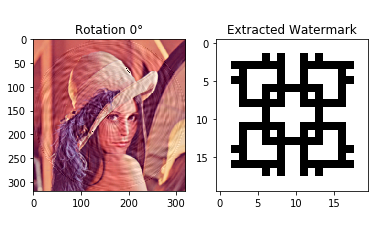

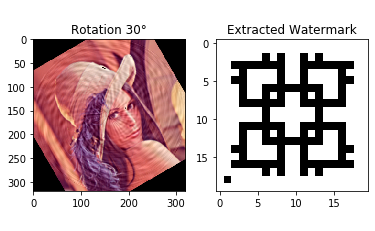

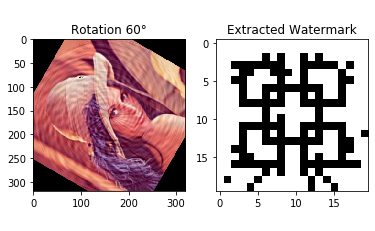

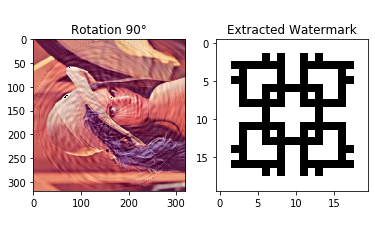

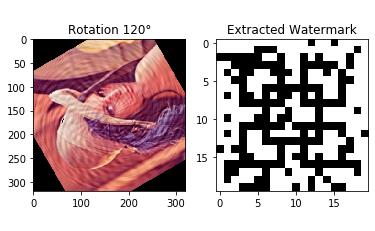

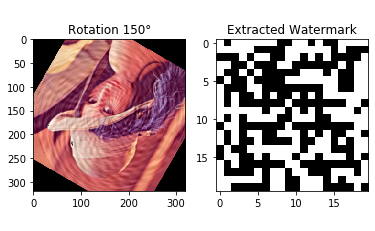

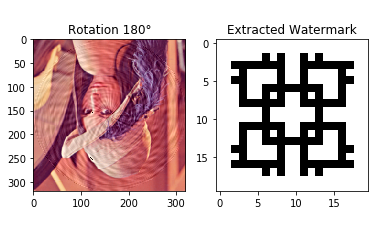

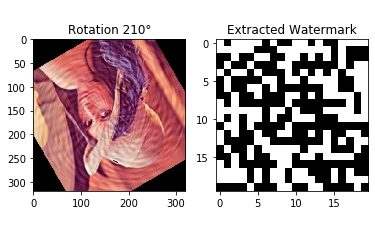

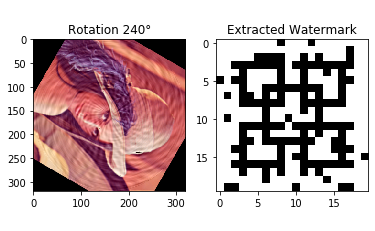

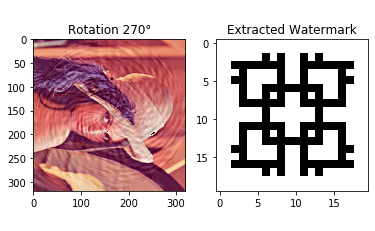

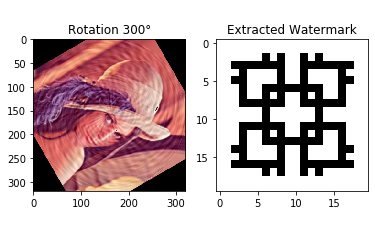

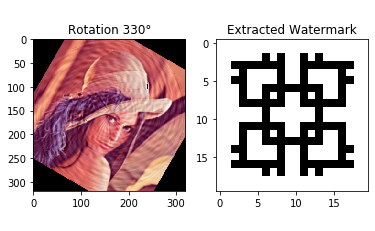

In [20]:
ROTATION_STEP = 30
rotation_results = []
for i in range(int(360 / ROTATION_STEP)):
    angle = i * ROTATION_STEP
    print(angle)
    title = 'Rotation {}°'.format(angle)
    img_rotated = attackRotation(IMG_WATERMARKED, angle)
    result = attack2(img_rotated, title, True)
    rotation_results.append((img_rotated, result, title))

for result in rotation_results:
    (img, result, title) = result
    displayAttackResult(img, result, title)

Progress: [####################] 100.0%
BE  :  55.0
BER :  13.75%
BE  :  47.0
BER :  11.75%
BE  :  38.0
BER :  9.50%
BE  :  21.0
BER :  5.25%
BE  :  6.0
BER :  1.50%
BE  :  0.0
BER :  0.00%
BE  :  7.0
BER :  1.75%
BE  :  25.0
BER :  6.25%
BE  :  40.0
BER :  10.00%
BE  :  58.0
BER :  14.50%
BE  :  104.0
BER :  26.00%


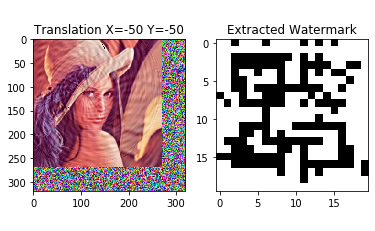

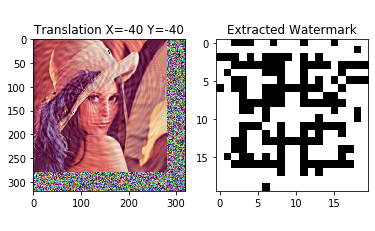

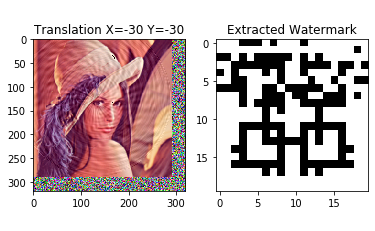

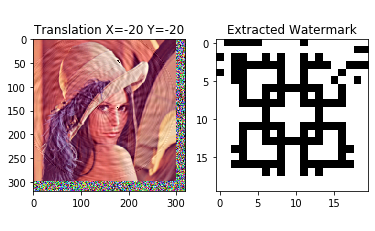

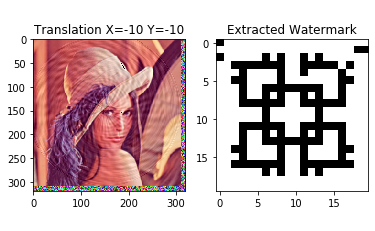

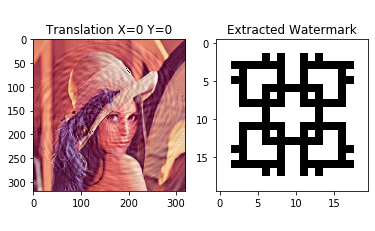

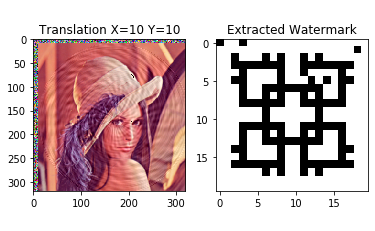

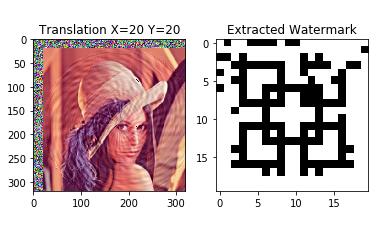

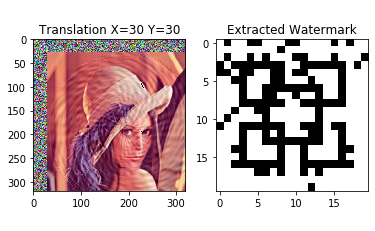

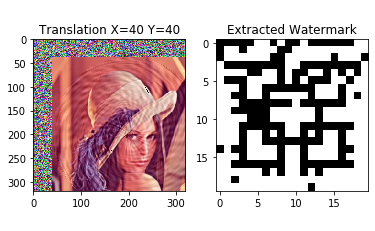

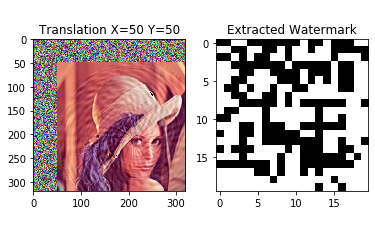

In [16]:
TRANSLATION_STEP = 10
translation_results = []
for i in range(-50, 51, TRANSLATION_STEP):
    title = 'Translation X={} Y={}'.format(i, i)
    img_translated = attackTranslateByPixel(IMG_WATERMARKED, i, i)
    result = attack2(img_translated, title, True)
    translation_results.append((img_translated, result, title))

for result in translation_results:
    (img, result, title) = result
    displayAttackResult(img, result, title)

In [17]:
def getSlice(pos, width):
    if(pos == -1):
        return (0, N)
    elif(pos == 0):
        return (width, N + width)
    else:
        return (2 * width, N + 2 * width)

def addFrame(img, xpos, ypos, width):
    frame = np.zeros((N + 2 * width, N + 2 * width, 3)).astype(np.uint8)
    (xs, xe) = getSlice(xpos, width)
    (ys, ye) = getSlice(ypos, width)
    frame[ys:ye, xs:xe, :] = img
    return frame

Progress: [####################] 100.0%
BE  :  0.0
BER :  0.00%
BE  :  1.0
BER :  0.25%
BE  :  47.0
BER :  11.75%
BE  :  3.0
BER :  0.75%
BE  :  100.0
BER :  25.00%
BE  :  5.0
BER :  1.25%
BE  :  150.0
BER :  37.50%
BE  :  2.0
BER :  0.50%
BE  :  52.0
BER :  13.00%


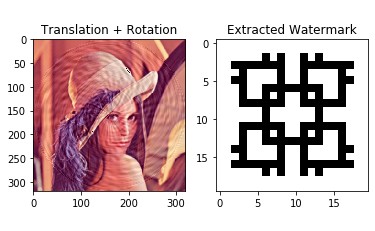

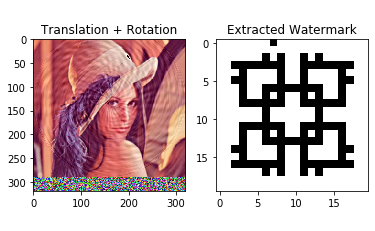

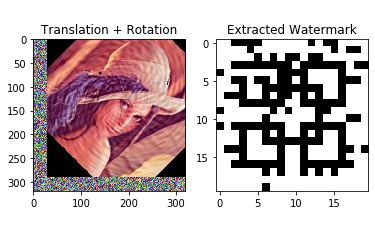

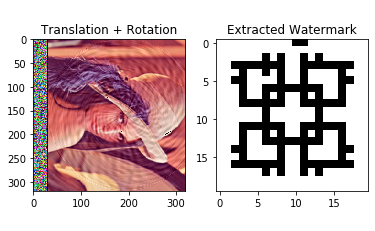

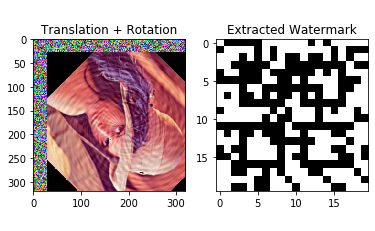

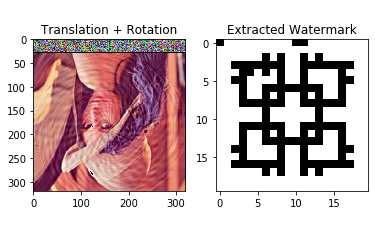

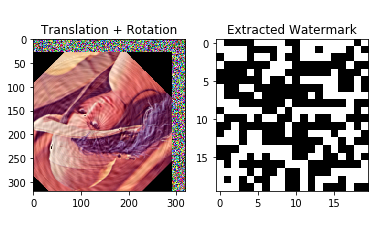

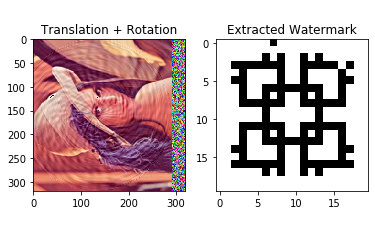

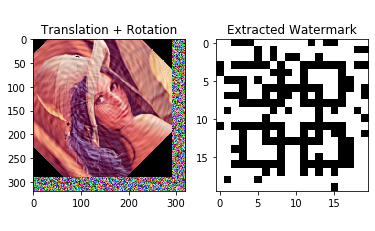

In [19]:
transrot_results = []

transrot_title = 'Translation + Rotation'
transrot_w = 30

transrot_img = np.copy(IMG_WATERMARKED)
transrot_img = attackTranslateByPixel(transrot_img, 0, 0)
transrot_result = attack2(transrot_img, transrot_title, True)
transrot_results.append((transrot_img, transrot_result, transrot_title))

transrot_img = np.copy(IMG_WATERMARKED)
transrot_img = attackTranslateByPixel(transrot_img, 0, -transrot_w)
transrot_result = attack2(transrot_img, transrot_title, True)
transrot_results.append((transrot_img, transrot_result, transrot_title))

transrot_img = attackRotation(IMG_WATERMARKED, -45)
transrot_img = attackTranslateByPixel(transrot_img, transrot_w, -transrot_w)
transrot_result = attack2(transrot_img, transrot_title, True)
transrot_results.append((transrot_img, transrot_result, transrot_title))

transrot_img = attackRotation(IMG_WATERMARKED, -90)
transrot_img = attackTranslateByPixel(transrot_img, transrot_w, 0)
transrot_result = attack2(transrot_img, transrot_title, True)
transrot_results.append((transrot_img, transrot_result, transrot_title))

transrot_img = attackRotation(IMG_WATERMARKED, -135)
transrot_img = attackTranslateByPixel(transrot_img, transrot_w, transrot_w)
transrot_result = attack2(transrot_img, transrot_title, True)
transrot_results.append((transrot_img, transrot_result, transrot_title))

transrot_img = attackRotation(IMG_WATERMARKED, -180)
transrot_img = attackTranslateByPixel(transrot_img, 0, transrot_w)
transrot_result = attack2(transrot_img, transrot_title, True)
transrot_results.append((transrot_img, transrot_result, transrot_title))

transrot_img = attackRotation(IMG_WATERMARKED, 135)
transrot_img = attackTranslateByPixel(transrot_img, -transrot_w, transrot_w)
transrot_result = attack2(transrot_img, transrot_title, True)
transrot_results.append((transrot_img, transrot_result, transrot_title))

transrot_img = attackRotation(IMG_WATERMARKED, 90)
transrot_img = attackTranslateByPixel(transrot_img, -transrot_w, 0)
transrot_result = attack2(transrot_img, transrot_title, True)
transrot_results.append((transrot_img, transrot_result, transrot_title))

transrot_img = attackRotation(IMG_WATERMARKED, 45)
transrot_img = attackTranslateByPixel(transrot_img, -transrot_w, -transrot_w)
transrot_result = attack2(transrot_img, transrot_title, True)
transrot_results.append((transrot_img, transrot_result, transrot_title))

for result in transrot_results:
    (img, result, title) = result
    displayAttackResult(img, result, title)